In [5]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

Mounted at /content/drive


In [6]:
from tqdm import tqdm

In [7]:
pd.set_option('display.max_columns', None)

In [ ]:
df = pd.read_parquet('/content/drive/MyDrive/Expedia/Data/exploded_df_100Krows.parquet')

In [ ]:
df.shape

(2574386, 29)

## Separating "Impressions" column into different rows

In [ ]:
def preprocess_and_explode(row):
    impressions_list = row['impressions'].split('|')
    new_rows = []
    for impression_group in tqdm(impressions_list):
        impressions = impression_group.split(',')
        new_row = row.copy()  # Copy the original row data
        for i, impression_value in enumerate(impressions):
            new_row[f'impression_{i+1}'] = impression_value
        new_rows.append(new_row)
    return pd.DataFrame(new_rows)

In [ ]:
# Explode the DataFrame by 'impressions' column
exploded_df = pd.concat([preprocess_and_explode(row) for _, row in df.iterrows()], ignore_index=True)

# Drop the original 'impressions' column
exploded_df.drop(columns=['impressions'], inplace=True)
exploded_df.shape

In [ ]:
file_path = '/content/drive/My Drive/Expedia/Data/exploded_df_10000rows.csv'
exploded_df.to_csv(file_path, index=False)

In [ ]:
exploded_df.rename(columns={'impression_1':'rank', 'impression_2':'prop_id','impression_3':'is_travel_ad','impression_4':'review_rating','impression_5':'review_count',
                            'impression_6':'star_rating', 'impression_7':'is_free_cancellation','impression_8':'is_drr','impression_9':'price_bucket','impression_10':'num_clicks',
                            'impression_11':'is_trans'}, inplace=True)
exploded_df.head()

In [ ]:
columns_converted = ['rank', 'prop_id', 'is_travel_ad', 'review_rating', 'review_count', 'star_rating',
                     'is_free_cancellation', 'is_drr', 'price_bucket', 'num_clicks', 'is_trans']

for i in columns_converted:
  exploded_df[i] = exploded_df[i].apply(lambda x: pd.to_numeric(x, errors='coerce'))

## Erase SearchID's where number of clicks is 0

In [ ]:
df_m = exploded_df.groupby('search_id', as_index=False).agg({'num_clicks':'sum', 'is_trans':'sum'})

no_s_id = df_m[df_m['num_clicks'] != 0]['search_id'].tolist()

exploded_df = exploded_df[exploded_df['search_id'].isin(no_s_id)]
exploded_df.shape

## Erase impressions ranked higher than 30

In [ ]:
condition = exploded_df['rank'] > 30
exploded_df = exploded_df[~condition]
print(exploded_df.shape)

## Add new ranking excluding Ads

In [ ]:
df_m3 = exploded_df[exploded_df['is_travel_ad'] == 0]

df_m3['rank_noad'] = df_m3.groupby('search_id').cumcount()+1

for i, j in exploded_df.iterrows():
  if i in df_m3.index:
    exploded_df.at[i,'rank_noad'] = int(df_m3.at[i,'rank_noad'])
  else:
    exploded_df.at[i,'rank_noad'] = int(0)

exploded_df.shape

## Erasing Search ID's with just one impression

In [ ]:
df_m = exploded_df.groupby('search_id', as_index=False).count()
multiple_impressions = df_m[df_m['count'] != 0]['search_id'].tolist()

In [ ]:
exploded_df = exploded_df[exploded_df['search_id'] in multiple_impressions]
exploded_df.shape

In [ ]:
file_path = '/content/drive/My Drive/Expedia/Data/exploded_df_100000rows.csv'
exploded_df.to_csv(file_path, index=False)

## Adding Amenities Datset

In [ ]:
df_amenities = pd.read_csv('/content/drive/MyDrive/Expedia/Data/amenities.tsv.gz', compression='gzip', sep='\t')

In [ ]:
exploded_df_merged = exploded_df.merge(df_amenities, on='prop_id', how='left')

In [ ]:
print(exploded_df_merged.shape)

exploded_df_merged.head()

## Cleaning Null Values

## Uploading PARQUET file

In [ ]:
df = pd.read_parquet('/content/drive/MyDrive/Expedia/Data/exploded_df_100Krows.parquet')

In [ ]:
df.shape

(2574386, 29)

In [ ]:
df.head()

,user_id,search_id,search_timestamp,point_of_sale,geo_location_country,is_mobile,destination_id,checkin_date,checkout_date,adult_count,child_count,infant_count,room_count,sort_type,length_of_stay,booking_window,search_day_of_week,search_hour_of_day,rank,is_travel_ad,review_rating,review_count,star_rating,is_free_cancellation,is_drr,price_bucket,num_clicks,is_trans,rank_noad
0,0,0,2021-07-02 19:38:00+00:00,2,1,0,898,2021-07-04,2021-07-05,2,0,0,1,RECOMMENDED,1.0,1.0,4,19,1,1,4.0,250.0,2.0,1,0,3.0,0,0,0.0
1,0,0,2021-07-02 19:38:00+00:00,2,1,0,898,2021-07-04,2021-07-05,2,0,0,1,RECOMMENDED,1.0,1.0,4,19,2,1,4.0,1000.0,2.0,1,0,4.0,0,0,0.0
2,0,0,2021-07-02 19:38:00+00:00,2,1,0,898,2021-07-04,2021-07-05,2,0,0,1,RECOMMENDED,1.0,1.0,4,19,3,0,5.0,700.0,3.0,1,0,3.0,0,0,1.0
3,0,0,2021-07-02 19:38:00+00:00,2,1,0,898,2021-07-04,2021-07-05,2,0,0,1,RECOMMENDED,1.0,1.0,4,19,4,0,4.0,250.0,2.0,1,0,3.0,0,0,2.0
4,0,0,2021-07-02 19:38:00+00:00,2,1,0,898,2021-07-04,2021-07-05,2,0,0,1,RECOMMENDED,1.0,1.0,4,19,5,0,4.0,625.0,2.0,0,0,1.0,0,0,3.0


In [ ]:
print(len(df['point_of_sale'].value_counts()))
print(len(df['geo_location_country'].value_counts()))
print(len(df['is_mobile'].value_counts()))
print(len(df['destination_id'].value_counts()))
print(len(df['sort_type'].value_counts()))

86
161
2
13274
8


In [ ]:
df['sort_type'].value_counts()

sort_type
RECOMMENDED                      2396181
PRICE ASCENDING                   125940
GUEST RATINGS DESCENDING           12344
STAR RATING DESCENDING             11887
SPECIAL - DIRECT HOTEL SEARCH      10229
DEALS                               8882
VACATION RENTAL                     8593
BEST_SELLER                          330
Name: count, dtype: int64

In [ ]:
df2 = df.copy()

In [ ]:
filtered_destination = df['destination_id'].value_counts()
df2 = df2[df2['destination_id'].isin(filtered_destination[filtered_destination > 14000].index)]

In [ ]:
df2 = df.copy()

In [ ]:
filtered_destination = df['destination_id'].value_counts()
df2 = df2[df2['destination_id'].isin(filtered_destination[filtered_destination > 20000].index)]

In [ ]:
df2.shape

(150362, 29)

In [ ]:
df2['review_count'] = df2['review_count'].fillna(0)

In [ ]:
df2['star_rating'] = df2['star_rating'].astype('category')
df2['star_rating'] = df2['star_rating'].cat.add_categories('Not Available')

In [ ]:
for i,j in tqdm(enumerate(df2['review_count']), total=len(df2)):
  if j > 0:
    df2.loc[i,'star_rating'] = 0
  else:
    df2.loc[i,'star_rating'] = 'Not Available'


In [ ]:
df['review_rating'] = df['review_rating'].astype('category')
df['review_rating'] = df['review_rating'].cat.add_categories('Not Available')
df['review_rating'] = df['review_rating'].fillna('Not Available')

In [ ]:
df['price_bucket'] = df['price_bucket'].astype('category')
df['price_bucket'] = df['price_bucket'].cat.add_categories('Not Available')
df['price_bucket'] = df['price_bucket'].fillna('Not Available')

In [ ]:
df.head()

,user_id,search_id,search_timestamp,point_of_sale,geo_location_country,is_mobile,destination_id,checkin_date,checkout_date,adult_count,child_count,infant_count,room_count,sort_type,length_of_stay,booking_window,search_day_of_week,search_hour_of_day,rank,is_travel_ad,review_rating,review_count,star_rating,is_free_cancellation,is_drr,price_bucket,num_clicks,is_trans,rank_noad
0,0,0,2021-07-02 19:38:00+00:00,2,1,0,898,2021-07-04,2021-07-05,2,0,0,1,RECOMMENDED,1.0,1.0,4,19,1,1,4.0,250.0,2.0,1,0,3.0,0,0,0.0
1,0,0,2021-07-02 19:38:00+00:00,2,1,0,898,2021-07-04,2021-07-05,2,0,0,1,RECOMMENDED,1.0,1.0,4,19,2,1,4.0,1000.0,2.0,1,0,4.0,0,0,0.0
2,0,0,2021-07-02 19:38:00+00:00,2,1,0,898,2021-07-04,2021-07-05,2,0,0,1,RECOMMENDED,1.0,1.0,4,19,3,0,5.0,700.0,3.0,1,0,3.0,0,0,1.0
3,0,0,2021-07-02 19:38:00+00:00,2,1,0,898,2021-07-04,2021-07-05,2,0,0,1,RECOMMENDED,1.0,1.0,4,19,4,0,4.0,250.0,2.0,1,0,3.0,0,0,2.0
4,0,0,2021-07-02 19:38:00+00:00,2,1,0,898,2021-07-04,2021-07-05,2,0,0,1,RECOMMENDED,1.0,1.0,4,19,5,0,4.0,625.0,2.0,0,0,1.0,0,0,3.0


In [ ]:
df = pd.read_parquet('/content/drive/MyDrive/Expedia/Data/exploded_df_top50dest_searched_100Krows.parquet')

In [ ]:
print(len(df['point_of_sale'].value_counts()))
print(len(df['geo_location_country'].value_counts()))
print(len(df['is_mobile'].value_counts()))
print(len(df['destination_id'].value_counts()))
print(len(df['sort_type'].value_counts()))
print(len(df['search_day_of_week'].value_counts()))
print(len(df['search_hour_of_day'].value_counts()))
print(len(df['is_travel_ad'].value_counts()))
print(len(df['review_rating'].value_counts()))
print(len(df['star_rating'].value_counts()))
print(len(df['is_free_cancellation'].value_counts()))
print(len(df['is_drr'].value_counts()))
print(len(df['price_bucket'].value_counts()))

61
71
2
50
7
7
24
2
6
7
2
2
5


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 575994 entries, 0 to 575993
Data columns (total 31 columns):
 #   Column                Non-Null Count   Dtype              
---  ------                --------------   -----              
 0   user_id               575994 non-null  int64              
 1   search_id             575994 non-null  int64              
 2   search_timestamp      575994 non-null  datetime64[ns, UTC]
 3   point_of_sale         575994 non-null  int64              
 4   geo_location_country  575994 non-null  int64              
 5   is_mobile             575994 non-null  int64              
 6   destination_id        575994 non-null  int64              
 7   checkin_date          575994 non-null  object             
 8   checkout_date         575994 non-null  object             
 9   adult_count           575994 non-null  int64              
 10  child_count           575994 non-null  int64              
 11  infant_count          575994 non-null  int64        

In [ ]:
df['is_mobile'] = df['is_mobile'].astype('category')
df['destination_id'] = df['destination_id'].astype('category')
df['sort_type'] = df['sort_type'].astype('category')
df['search_day_of_week'] = df['search_day_of_week'].astype('category')
df['is_travel_ad'] = df['is_travel_ad'].astype('category')
df['is_free_cancellation'] = df['is_free_cancellation'].astype('category')
df['is_drr'] = df['is_drr'].astype('category')

In [ ]:
df.head()

,user_id,search_id,search_timestamp,point_of_sale,geo_location_country,is_mobile,destination_id,checkin_date,checkout_date,adult_count,child_count,infant_count,room_count,sort_type,length_of_stay,booking_window,search_day_of_week,search_hour_of_day,rank,is_travel_ad,review_rating,review_count,star_rating,is_free_cancellation,is_drr,price_bucket,num_clicks,is_trans,rank_noad,checkin_day,checkout_day
0,3,3,2021-07-16 01:08:00+00:00,12,1,0,13,2021-08-25,2021-08-28,2,0,0,1,RECOMMENDED,3.0,39.0,4,1,1,1,4.0,1625.0,5.0,0,0,5.0,0,0,0.0,2,2
1,3,3,2021-07-16 01:08:00+00:00,12,1,0,13,2021-08-25,2021-08-28,2,0,0,1,RECOMMENDED,3.0,39.0,4,1,2,1,4.0,275.0,4.0,1,1,4.0,0,0,0.0,2,2
2,3,3,2021-07-16 01:08:00+00:00,12,1,0,13,2021-08-25,2021-08-28,2,0,0,1,RECOMMENDED,3.0,39.0,4,1,3,1,4.0,1275.0,5.0,1,0,4.0,0,0,0.0,2,2
3,3,3,2021-07-16 01:08:00+00:00,12,1,0,13,2021-08-25,2021-08-28,2,0,0,1,RECOMMENDED,3.0,39.0,4,1,4,1,5.0,1250.0,5.0,1,1,5.0,0,0,0.0,2,2
4,3,3,2021-07-16 01:08:00+00:00,12,1,0,13,2021-08-25,2021-08-28,2,0,0,1,RECOMMENDED,3.0,39.0,4,1,5,0,4.0,5200.0,5.0,1,1,5.0,0,0,1.0,2,2


In [ ]:
df['star_rating'] = df['star_rating'].astype('category')
df['review_rating'] = df['review_rating'].astype('category')
df['price_bucket'] = df['price_bucket'].astype('category')

In [ ]:
df2 = df.copy()

## LIGHTGBM

In [361]:
df = pd.read_parquet('/content/drive/MyDrive/Expedia/Data/exploded_df_top50dest_searched_100Krows.parquet')

In [362]:
df.shape

(80386, 29)

In [363]:
df_m = df.groupby('search_id', as_index=False).agg({'num_clicks':'sum', 'is_trans':'sum'})

no_s_id = df_m[df_m['num_clicks'] != 0]['search_id'].tolist()

df = df[df['search_id'].isin(no_s_id)]
df.shape

(80386, 29)

In [365]:
df.groupby('search_id').agg({'num_clicks':'sum', 'is_trans':'sum'})

,num_clicks,is_trans
search_id,,
2,1,0
82,2,0
113,1,1
139,2,0
141,4,0
...,...,...
99431,2,0
99508,2,0
99663,1,0


In [366]:
from sklearn.datasets import dump_svmlight_file
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import xgboost as xgb
from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.impute import KNNImputer
from sklearn.model_selection import GroupShuffleSplit

from sklearn.metrics import ndcg_score

In [367]:
df.shape

(80386, 29)

In [368]:
df['review_count'] = df['review_count'].fillna(0)

In [369]:
df['star_rating'] = df['star_rating'].astype('category')
df['star_rating'] = df['star_rating'].cat.add_categories('Not Available')
df['star_rating'] = df['star_rating'].fillna('Not Available')

In [370]:
df['review_rating'] = df['review_rating'].astype('category')
df['review_rating'] = df['review_rating'].cat.add_categories('Not Available')
df['review_rating'] = df['review_rating'].fillna('Not Available')

In [371]:
df['price_bucket'] = df['price_bucket'].astype('category')
df['price_bucket'] = df['price_bucket'].cat.add_categories('Not Available')
df['price_bucket'] = df['price_bucket'].fillna('Not Available')

In [372]:
df['is_mobile'] = df['is_mobile'].astype('category')
df['destination_id'] = df['destination_id'].astype('category')
df['sort_type'] = df['sort_type'].astype('category')
df['search_day_of_week'] = df['search_day_of_week'].astype('category')
df['is_travel_ad'] = df['is_travel_ad'].astype('category')
df['is_free_cancellation'] = df['is_free_cancellation'].astype('category')
df['is_drr'] = df['is_drr'].astype('category')

In [333]:
df2=df.copy()

In [373]:
#Assigning +1 per each click and +2 per booking, having as max value 3
df2['relevance'] = df2['num_clicks'] + 2 * df2['is_trans']
df2.loc[df2['relevance'] > 3, 'relevance'] = 3
df2['relevance'].value_counts()

relevance
0    75351
1     4301
3      441
2      293
Name: count, dtype: int64

In [334]:
#1 if there is a click and value 2 if there is a booking
'''
for j,i in df2.iterrows():
  if i['num_clicks'] == 0:
    df2.loc[j,'relevance'] = 0
  elif i['num_clicks'] >= 1 & i['is_trans'] == 0:
    df2.loc[j,'relevance'] = 1
  elif i['is_trans'] >= 1:
    df2.loc[j,'relevance'] = 2

df2['relevance'].value_counts()
'''

relevance
0.0    75351
1.0     4653
2.0      382
Name: count, dtype: int64

In [374]:
df2.groupby('search_id').agg({'relevance':'sum'})

,relevance
search_id,
2,1
82,2
113,3
139,2
141,4
...,...
99431,2
99508,2
99663,1


In [375]:
def split_by_qid(df2, test_size):
    gss = GroupShuffleSplit(test_size=test_size, n_splits=1, random_state=42)
    ids = df2['search_id'].unique()
    train_idx, test_idx = next(gss.split(ids, groups=ids))
    return df2[df2['search_id'].isin(ids[train_idx])], df2[df2['search_id'].isin(ids[test_idx])]

#_, temp_df = split_by_qid(df2, test_size=0.2)
train_df, test_df = split_by_qid(df2, test_size=0.3)

train_df.shape, test_df.shape

((56325, 30), (24061, 30))

In [376]:
train_df.columns

Index(['user_id', 'search_id', 'search_timestamp', 'point_of_sale',
       'geo_location_country', 'is_mobile', 'destination_id', 'checkin_date',
       'checkout_date', 'adult_count', 'child_count', 'infant_count',
       'room_count', 'sort_type', 'length_of_stay', 'booking_window',
       'search_day_of_week', 'search_hour_of_day', 'rank', 'is_travel_ad',
       'review_rating', 'review_count', 'star_rating', 'is_free_cancellation',
       'is_drr', 'price_bucket', 'num_clicks', 'is_trans', 'rank_noad',
       'relevance'],
      dtype='object')

In [377]:
train_df.drop(columns=['user_id','search_timestamp','checkin_date','checkout_date','rank_noad','rank','num_clicks','is_trans'], inplace=True)
test_df.drop(columns=['user_id','search_timestamp','checkin_date','checkout_date','rank_noad','rank','num_clicks','is_trans'], inplace=True)

train_df.shape, test_df.shape

<ipython-input-377-efdda8367a29>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop(columns=['user_id','search_timestamp','checkin_date','checkout_date','rank_noad','rank','num_clicks','is_trans'], inplace=True)
<ipython-input-377-efdda8367a29>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop(columns=['user_id','search_timestamp','checkin_date','checkout_date','rank_noad','rank','num_clicks','is_trans'], inplace=True)


((56325, 22), (24061, 22))

In [378]:
X_train = train_df.drop(columns=['relevance'])
y_train = train_df['relevance']

X_test = test_df.drop(columns=['relevance'])
y_test = test_df['relevance']

query_id_train = X_train['search_id']

query_id_test = X_test['search_id']

In [379]:
categorical_features = X_train.select_dtypes(include=['category']).columns.tolist()
numeric_features = X_train.select_dtypes(exclude=['category']).columns.tolist()

numeric_features.remove('search_id')

categorical_features, numeric_features

(['is_mobile',
  'destination_id',
  'sort_type',
  'search_day_of_week',
  'is_travel_ad',
  'review_rating',
  'star_rating',
  'is_free_cancellation',
  'is_drr',
  'price_bucket'],
 ['point_of_sale',
  'geo_location_country',
  'adult_count',
  'child_count',
  'infant_count',
  'room_count',
  'length_of_stay',
  'booking_window',
  'search_hour_of_day',
  'review_count'])

In [380]:
scaler=StandardScaler()
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

In [381]:
X_train = pd.get_dummies(X_train, columns=categorical_features)
X_test = pd.get_dummies(X_test, columns=categorical_features)

In [382]:
X_train.shape, X_test.shape

((56325, 102), (24061, 102))

In [187]:
#file_path = 'train_allrank.svmlight'
#dump_svmlight_file(X_train, y_train, f=file_path, query_id=query_id_train)

#file_path = 'test_allrank.svmlight'
#dump_svmlight_file(X_test, y_test, f=file_path, query_id=query_id_test)

In [383]:
X_train_2 = X_train.drop(columns=['search_id'])
X_train_2.head()

,point_of_sale,geo_location_country,adult_count,child_count,infant_count,room_count,length_of_stay,booking_window,search_hour_of_day,review_count,is_mobile_0,is_mobile_1,destination_id_2,destination_id_3,destination_id_4,destination_id_5,destination_id_6,destination_id_7,destination_id_8,destination_id_9,destination_id_10,destination_id_11,destination_id_12,destination_id_13,destination_id_14,destination_id_15,destination_id_16,destination_id_17,destination_id_19,destination_id_20,destination_id_21,destination_id_22,destination_id_23,destination_id_24,destination_id_25,destination_id_26,destination_id_28,destination_id_29,destination_id_36,destination_id_37,destination_id_40,destination_id_42,destination_id_43,destination_id_44,destination_id_48,destination_id_49,destination_id_51,destination_id_58,destination_id_59,destination_id_60,destination_id_61,destination_id_69,destination_id_72,destination_id_78,destination_id_81,destination_id_83,destination_id_86,destination_id_92,destination_id_102,destination_id_106,destination_id_202,destination_id_344,sort_type_DEALS,sort_type_GUEST RATINGS DESCENDING,sort_type_PRICE ASCENDING,sort_type_RECOMMENDED,sort_type_SPECIAL - DIRECT HOTEL SEARCH,sort_type_STAR RATING DESCENDING,sort_type_VACATION RENTAL,search_day_of_week_0,search_day_of_week_1,search_day_of_week_2,search_day_of_week_3,search_day_of_week_4,search_day_of_week_5,search_day_of_week_6,is_travel_ad_0,is_travel_ad_1,review_rating_0.0,review_rating_1.0,review_rating_2.0,review_rating_3.0,review_rating_4.0,review_rating_5.0,review_rating_Not Available,star_rating_1.0,star_rating_2.0,star_rating_3.0,star_rating_4.0,star_rating_5.0,star_rating_Not Available,is_free_cancellation_0,is_free_cancellation_1,is_drr_0,is_drr_1,price_bucket_1.0,price_bucket_2.0,price_bucket_3.0,price_bucket_4.0,price_bucket_5.0,price_bucket_Not Available
0,-0.285078,-0.220243,-0.221011,-0.351824,0.0,0.0,0.733361,-0.277356,-1.575853,-0.211706,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True,False,True,False,True,False,False,False,False
1,-0.285078,-0.220243,-0.221011,-0.351824,0.0,0.0,0.733361,-0.277356,-1.575853,-0.275403,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,True,False,True,False,False,False,False,False
2,-0.285078,-0.220243,-0.221011,-0.351824,0.0,0.0,0.733361,-0.277356,-1.575853,-0.176320,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True,False,True,False,False,False,True,False,False
3,-0.285078,-0.220243,-0.221011,-0.351824,0.0,0.0,0.733361,-0.277356,-1.575853,0.064311,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False

In [405]:
import lightgbm as lgb

X_train_arr = X_train_2.values

y_train_array = y_train.values.ravel()

query_group_sizes_train = []
for i in X_train['search_id'].value_counts():
  query_group_sizes_train.append(i)

query_group_sizes_train_arr = np.array(query_group_sizes_train)


# Define LightGBM parameters for ranker
params = {
    'objective': 'lambdarank',  # Ranking objective
    'metric': 'ndcg',  # Evaluation metric
    'learning_rate': 0.01,
    'verbose': 0
}


train_data = lgb.Dataset(X_train_arr, label=y_train_array, group=query_group_sizes_train_arr)


num_rounds = 1000
ranker_model = lgb.train(params, train_data, num_rounds)

In [406]:
X_test_2 = X_test.drop(columns=['search_id'])
X_test_arr = X_test_2.values

y_test_array = y_test.values.ravel()

query_group_sizes_test = []
for i in X_test['search_id'].value_counts():
  query_group_sizes_test.append(i)
query_group_sizes_test_arr = np.array(query_group_sizes_test)

test_data = lgb.Dataset(X_test_arr, label=y_test_array, group=query_group_sizes_test_arr, reference=train_data)

In [407]:
test_predictions = ranker_model.predict(X_test_arr.astype(float))

y_test_df = pd.DataFrame({'relevance_score': y_test, 'predicted_ranking': test_predictions})
y_test_df.head()

,relevance_score,predicted_ranking
540,0,-0.215409
541,0,-0.076921
542,0,0.065356
543,1,0.205849
544,1,-0.301407


In [408]:
y_test_df.shape

(24061, 2)

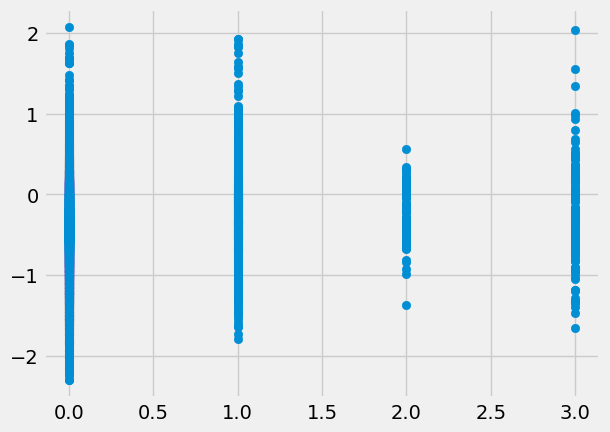

In [409]:
plt.style.use('fivethirtyeight')
plt.scatter(y_test_df["relevance_score"], y_test_df["predicted_ranking"])
plt.show()

In [410]:
print('Mean predicted score for 0 relevance values:',np.mean(y_test_df[y_test_df['relevance_score'] == 0]['predicted_ranking']))
print('Mean predicted score for 1 relevance values:',np.mean(y_test_df[y_test_df['relevance_score'] == 1]['predicted_ranking']))
print('Mean predicted score for 2 relevance values:',np.mean(y_test_df[y_test_df['relevance_score'] == 2]['predicted_ranking']))
print('Mean predicted score for 3 relevance values:',np.mean(y_test_df[y_test_df['relevance_score'] == 3]['predicted_ranking']))

Mean predicted score for 0 relevance values: -0.44507391644552735
Mean predicted score for 1 relevance values: -0.23990124273987207
Mean predicted score for 2 relevance values: -0.2296533399248225
Mean predicted score for 3 relevance values: -0.2479683240700128


In [412]:
column_names = []
for i in [3,91,2,1,95,0,6,8,7,9]:
  column_names.append(X_train_2.columns[i])

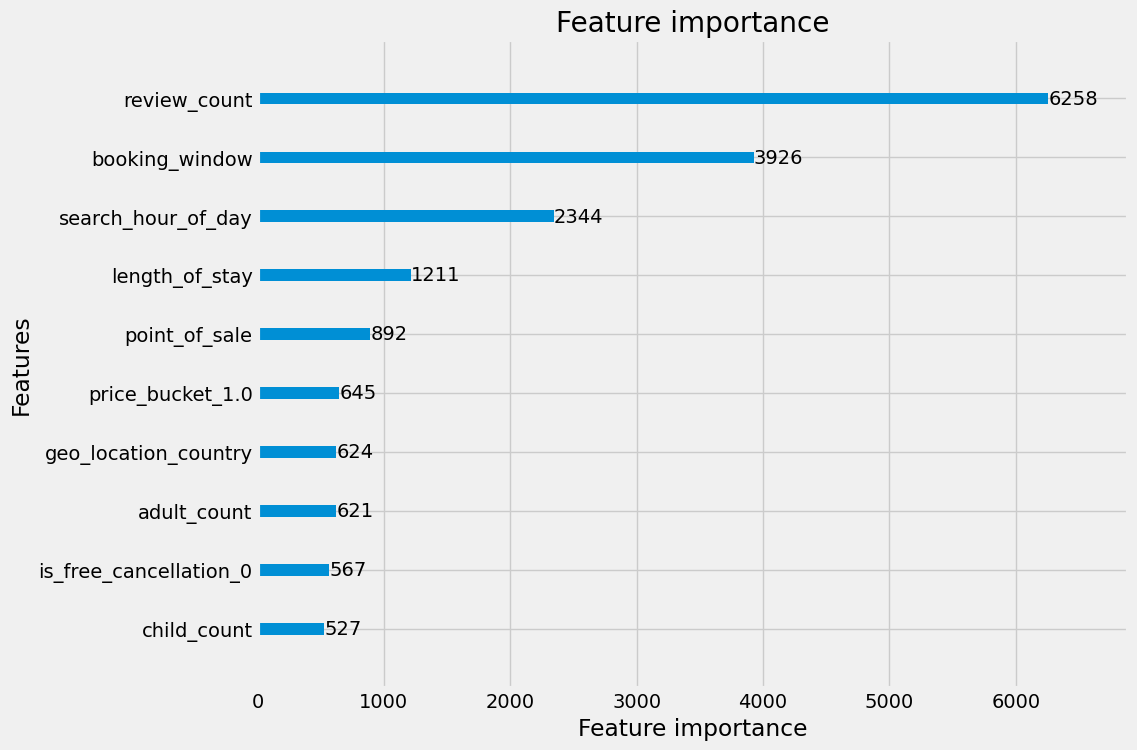

In [413]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.style.use('fivethirtyeight')
lgb.plot_importance(ranker_model, max_num_features=10, ax=ax)
ax.set_yticklabels(column_names)
plt.show()

## Calculating NDCG for the predicted scores

In [414]:
test_df['predicted_score'] = test_predictions
test_df.shape

<ipython-input-414-d97ebf8bfbaa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['predicted_score'] = test_predictions


(24061, 23)

In [420]:
ndcg_per_query_lgbm_all = []
for group_name, group_df in test_df.groupby('search_id'):
    pred_scores = group_df['predicted_score']
    true_labels = sorted(group_df['relevance'],reverse=True)  # Assuming predicted scores are the same as true labels
    ndcg = ndcg_score([true_labels], [pred_scores])
    ndcg_per_query_lgbm_all.append(ndcg)

print('NDCG mean taking into account all values of the ranking', np.mean(ndcg_per_query_lgbm_all))

NDCG mean taking into account all values of the ranking 0.4594480736348543


In [421]:
ndcg_per_query_lgbm_k20 = []
for group_name, group_df in test_df.groupby('search_id'):
    pred_scores = group_df['predicted_score']
    true_labels = sorted(group_df['relevance'],reverse=True)  # Assuming predicted scores are the same as true labels
    ndcg = ndcg_score([true_labels], [pred_scores], k=20)
    ndcg_per_query_lgbm_k20.append(ndcg)

print('NDCG mean taking into account the first 20 values of the ranking', np.mean(ndcg_per_query_lgbm_k20))

NDCG mean taking into account the first 20 values of the ranking 0.4197705182467065


In [422]:
ndcg_per_query_lgbm_k10 = []
for group_name, group_df in test_df.groupby('search_id'):
    pred_scores = group_df['predicted_score']
    true_labels = sorted(group_df['relevance'],reverse=True)  # Assuming predicted scores are the same as true labels
    ndcg = ndcg_score([true_labels], [pred_scores], k=10)
    ndcg_per_query_lgbm_k10.append(ndcg)

print('NDCG mean taking into account the first 10 values of the ranking', np.mean(ndcg_per_query_lgbm_k10))

NDCG mean taking into account the first 10 values of the ranking 0.3451644557307615


In [423]:
ndcg_per_query_lgbm_k5 = []
for group_name, group_df in test_df.groupby('search_id'):
    pred_scores = group_df['predicted_score']
    true_labels = sorted(group_df['relevance'],reverse=True)  # Assuming predicted scores are the same as true labels
    ndcg = ndcg_score([true_labels], [pred_scores], k=5)
    ndcg_per_query_lgbm_k5.append(ndcg)

print('NDCG mean taking into account the first 5 values of the ranking', np.mean(ndcg_per_query_lgbm_k5))

NDCG mean taking into account the first 5 values of the ranking 0.27456057836859116


In [424]:
ndcg_per_query_lgbm_k1 = []
for group_name, group_df in test_df.groupby('search_id'):
    pred_scores = group_df['predicted_score']
    true_labels = sorted(group_df['relevance'],reverse=True)  # Assuming predicted scores are the same as true labels
    ndcg = ndcg_score([true_labels], [pred_scores], k=1)
    ndcg_per_query_lgbm_k1.append(ndcg)

print('NDCG mean taking into account the first 1 values of the ranking', np.mean(ndcg_per_query_lgbm_k1))

NDCG mean taking into account the first 1 values of the ranking 0.18134920634920632


In [196]:
'''
# Calculate NDCG score per query
ndcg_per_query_all = []
start_idx = 0
for group_size in query_group_sizes_test_arr:
    end_idx = start_idx + group_size
    true_labels = np.sort(y_test_array[start_idx:end_idx])[::-1]
    pred_scores = test_predictions[start_idx:end_idx]
    ndcg = ndcg_score([true_labels], [pred_scores])
    ndcg_per_query_all.append(ndcg)
    start_idx = end_idx

print("NDCG per query:", ndcg_per_query_all)
print("Mean NDCG:", np.mean(ndcg_per_query_all))
print(len(ndcg_per_query_all))
print(X_test['search_id'].nunique())
'''

NDCG per query: [0.3214167066127604, 0.3030671453540137, 0.21274605355336274, 0.463513540760659, 0.35620718710802235, 0.27894294565112965, 0.30852755538171533, 0.3154648767857289, 0.21030991785715258, 0.36215407379234504, 0.34407004351137266, 0.6847279431224611, 0.3977981569336171, 0.24732527105911295, 0.36847441342662796, 0.3784164111154849, 0.2697537276230929, 0.22595703645726406, 0.2559580248098152, 0.23137821315975948, 0.20584683246043411, 0.38685280723454163, 0.302643559198199, 0.5570247215350469, 0.23540891336663794, 0.3108947010438266, 0.22106472945750344, 0.35620718710802235, 0.38895809436805423, 0.0, 0.588617436717873, 0.35590190813216166, 0.36243418501131447, 0.28906482631788766, 1.0, 0.42386243864745554, 0.2708035414664961, 0.6309297535714573, 0.9197207891481877, 0.4509167926889799, 0.49666207838883264, 0.7392665298429149, 0.43510120664030877, 1.0, 0.38685280723454163, 0.4306765580733929, 0.3333333333333335, 0.7809096050200935, 0.6309297535714573, 0.5, 0.38685280723454163, 0

In [162]:
'''
# Calculate NDCG score per query
ndcg_per_query_all = []
start_idx = 0
for group_size in query_group_sizes_test_arr:
    end_idx = start_idx + group_size
    true_labels = y_test_array[start_idx:end_idx]
    pred_scores = test_predictions[start_idx:end_idx]
    ndcg = ndcg_score([true_labels], [pred_scores])
    ndcg_per_query_all.append(ndcg)
    start_idx = end_idx

print("NDCG per query:", ndcg_per_query_all)
print("Mean NDCG:", np.mean(ndcg_per_query_all))
print(len(ndcg_per_query_all))
print(X_test['search_id'].nunique())
'''

NDCG per query: [0.3656367148009526, 0.2825855589527339, 0.2559580248098152, 0.513731794275724, 0.38685280723454163, 0.21810429198553116, 0.6240505200038378, 0.38685280723454163, 0.4306765580733929, 0.3706656904013185, 0.31704041646102765, 0.7859179601476224, 0.26335857466483625, 0.3333333333333335, 0.8184209655592564, 0.39227380201641415, 0.39991709360355915, 1.0, 0.38685280723454163, 0.28906482631788766, 0.3154648767857289, 0.20801459767650954, 0.2832683419367569, 0.3290750888408867, 0.28906482631788766, 0.49451339166233815, 0.21810429198553116, 0.38685280723454163, 0.4824755593907551, 0.0, 0.5593747413620771, 0.8175295903539447, 0.4144918668898639, 0.27894294565112965, 0.4306765580733929, 0.32341236039713706, 0.45560514958746057, 0.4306765580733929, 0.3544692287064792, 0.4410033534795527, 0.47068551880180887, 0.8457371962750816, 0.8065735963827294, 1.0, 0.23981246656813138, 0.4306765580733929, 0.3333333333333335, 0.9100146011600025, 0.6309297535714573, 0.2153382790366969, 0.43067655

In [84]:
'''
test_ndcg = ndcg_score([y_test], [test_predictions])
print("Test NDCG Score for All:", test_ndcg)

test_ndcg = ndcg_score([y_test], [test_predictions], k=5)
print("Test NDCG Score 5k:", test_ndcg)

test_ndcg = ndcg_score([y_test], [test_predictions], k=10)
print("Test NDCG Score 10k:", test_ndcg)

test_ndcg = ndcg_score([y_test], [test_predictions], k=20)
print("Test NDCG Score 20k:", test_ndcg)
'''

Test NDCG Score for All: 0.6578695512023721
Test NDCG Score 5k: 0.17654490573801399
Test NDCG Score 10k: 0.13665030494884475
Test NDCG Score 20k: 0.147805709612043


In [ ]:
'''
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.metrics import ndcg_score

# Define a simple neural network architecture
def create_model(input_dim):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))  # Output layer for pointwise approach
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))
    return model

# Convert query_id_train and query_id_test to numpy arrays
query_id_train_np = query_id_train.to_numpy().astype(np.float32)
query_id_test_np = query_id_test.to_numpy().astype(np.float32)

# Convert y_train and y_test to numpy arrays
y_train_np = y_train.to_numpy().astype(np.float32)
y_test_np = y_test.to_numpy().astype(np.float32)

# Define input dimensions (number of features)
input_dim = X_train.shape[1]

# Create the neural network model
model = create_model(input_dim)

model.fit(X_train.values, y_train, epochs=10, batch_size=32, verbose=1)
'''

## Computing NDCG for the original Dataset

In [121]:
df_ex = pd.read_parquet('/content/drive/MyDrive/Expedia/Data/exploded_df_100Krows.parquet')

In [123]:
import tqdm as tqdm

In [122]:
df_ex.shape

(2574386, 29)

In [124]:
df_m = df_ex.groupby('search_id', as_index=False).agg({'num_clicks':'sum', 'is_trans':'sum'})

no_s_id = df_m[df_m['num_clicks'] != 0]['search_id'].tolist()

df_ex = df_ex[df_ex['search_id'].isin(no_s_id)]
df_ex.shape

(466018, 29)

In [125]:
df_ex2 = df_ex.copy()
df_ex2['relevance'] = df_ex2['num_clicks'] + 2 * df_ex2['is_trans']
df_ex2.loc[df_ex2['relevance'] > 3, 'relevance'] = 3
df_ex2['relevance'].value_counts()

relevance
0    435945
1     25565
3      2420
2      2088
Name: count, dtype: int64

In [425]:
ndcg_per_query_df = []
for group_name, group_df in df_ex2.groupby('search_id'):
    pred_scores = group_df['relevance']
    true_labels = sorted(pred_scores,reverse=True)  # Assuming predicted scores are the same as true labels
    ndcg = ndcg_score([true_labels], [pred_scores])
    ndcg_per_query_df.append(ndcg)

print('NDCG mean taking into account all values of the ranking', np.mean(ndcg_per_query_df))

NDCG mean taking into account all values of the ranking 0.624264756239976


In [426]:
ndcg_per_query_df_k20 = []
for group_name, group_df in df_ex2.groupby('search_id'):
    pred_scores = group_df['relevance']
    true_labels = sorted(pred_scores,reverse=True)  # Assuming predicted scores are the same as true labels
    ndcg = ndcg_score([true_labels], [pred_scores], k=20)
    ndcg_per_query_df_k20.append(ndcg)

print('NDCG mean taking into account first 20 values of the ranking', np.mean(ndcg_per_query_df_k20))

NDCG mean taking into account first 20 values of the ranking 0.5819610183289134


In [427]:
ndcg_per_query_df_k10 = []
for group_name, group_df in df_ex2.groupby('search_id'):
    pred_scores = group_df['relevance']
    true_labels = sorted(pred_scores,reverse=True)  # Assuming predicted scores are the same as true labels
    ndcg = ndcg_score([true_labels], [pred_scores], k=10)
    ndcg_per_query_df_k10.append(ndcg)

print('NDCG mean taking into account first 10 values of the ranking', np.mean(ndcg_per_query_df_k10))

NDCG mean taking into account first 10 values of the ranking 0.5283816716872791


In [428]:
ndcg_per_query_df_k5 = []
for group_name, group_df in df_ex2.groupby('search_id'):
    pred_scores = group_df['relevance']
    true_labels = sorted(pred_scores,reverse=True)  # Assuming predicted scores are the same as true labels
    ndcg = ndcg_score([true_labels], [pred_scores], k=5)
    ndcg_per_query_df_k5.append(ndcg)

print('NDCG mean taking into account first 5 values of the ranking', np.mean(ndcg_per_query_df_k5))

NDCG mean taking into account first 5 values of the ranking 0.49070150670203


In [429]:
ndcg_per_query_df_k1 = []
for group_name, group_df in df_ex2.groupby('search_id'):
    pred_scores = group_df['relevance']
    true_labels = sorted(pred_scores,reverse=True)  # Assuming predicted scores are the same as true labels
    ndcg = ndcg_score([true_labels], [pred_scores], k=1)
    ndcg_per_query_df_k1.append(ndcg)

print('NDCG mean taking into account first of the ranking', np.mean(ndcg_per_query_df_k1))

NDCG mean taking into account first of the ranking 0.4424592753545088


In [441]:
df_ndcg = [np.mean(ndcg_per_query_df), np.mean(ndcg_per_query_df_k20), np.mean(ndcg_per_query_df_k10), np.mean(ndcg_per_query_df_k5), np.mean(ndcg_per_query_df_k1)]
lgbm_ndcg = [np.mean(ndcg_per_query_lgbm_all), np.mean(ndcg_per_query_lgbm_k20), np.mean(ndcg_per_query_lgbm_k10), np.mean(ndcg_per_query_lgbm_k5), np.mean(ndcg_per_query_lgbm_k1)]
results_df = pd.DataFrame({"Ks":['All', 'K20', 'K10', 'K5', 'K1'],'Dataframe_ndcg':df_ndcg, 'LGBM_ndcg': lgbm_ndcg})

In [449]:
results_df

,Ks,Dataframe_ndcg,LGBM_ndcg
0,All,0.624265,0.459448
1,K20,0.581961,0.419771
2,K10,0.528382,0.345164
3,K5,0.490702,0.274561
4,K1,0.442459,0.181349


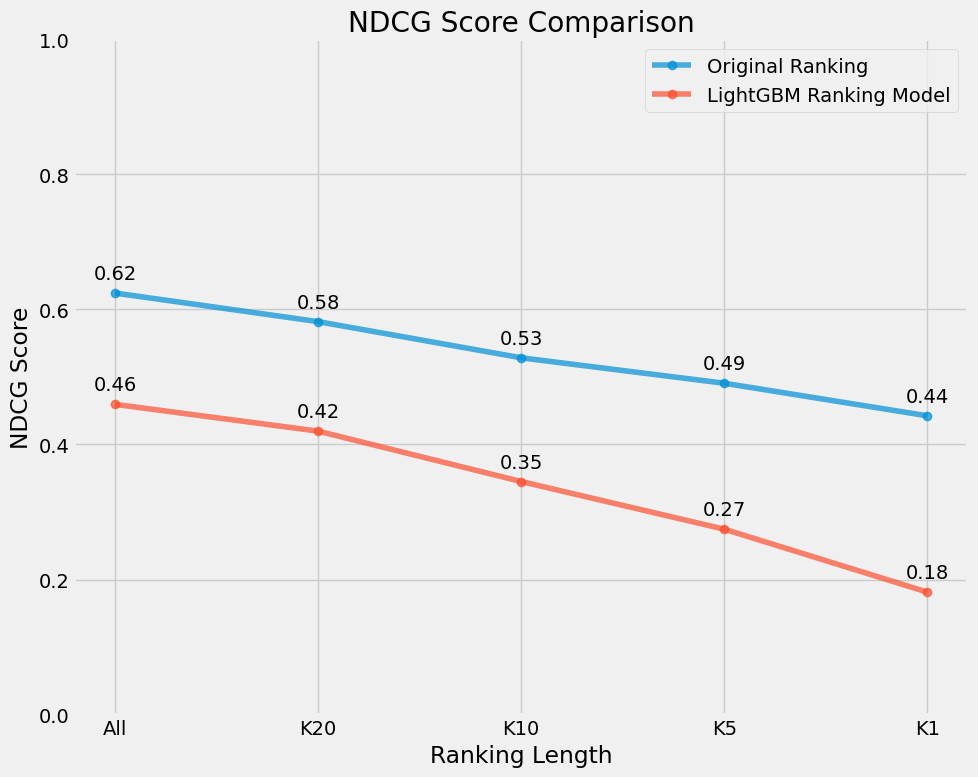

In [459]:
plt.style.use('fivethirtyeight')

plt.figure(figsize=(10,8))

plt.plot(results_df["Ks"], results_df['Dataframe_ndcg'], marker='o', label='Original Ranking', alpha=0.7)
plt.plot(results_df["Ks"], results_df['LGBM_ndcg'], marker='o', label='LightGBM Ranking Model', alpha=0.7)

plt.legend()

for x, y in zip(results_df["Ks"], results_df['Dataframe_ndcg']):
    plt.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')

for x, y in zip(results_df["Ks"], results_df['LGBM_ndcg']):
    plt.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel('Ranking Length')
plt.ylabel('NDCG Score')
plt.title('NDCG Score Comparison')

plt.ylim(0,1)

plt.tight_layout()
plt.show()

## Verifying NDCG function works correctly

In [215]:
ndcg_per_query = []
for group_name, group_df in test_df.groupby('search_id'):
    pred_scores = group_df['relevance']
    true_labels = sorted(pred_scores,reverse=True)  # Assuming predicted scores are the same as true labels
    ndcg = ndcg_score([true_labels], [pred_scores])
    ndcg_per_query.append(ndcg)

In [216]:
ndcg_per_query[0]

0.28143382902899594

In [217]:
INDCG = sorted(test_df[test_df['search_id'] == 281]['relevance'].tolist(), reverse=True)
DCG = test_df[test_df['search_id'] == 281]['relevance'].tolist()
ndcg_score([INDCG], [DCG])

0.28143382902899594

In [156]:
sorted(a, reverse=True)

[1, 0, 0, 0]

In [157]:
a

[0, 0, 0, 1]

In [285]:
a = [0,0,0,1]
b = a
ndcg_score([a], [b])

1.0